[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/rkarmaka/Global-BioImaging-Image-Data-2025-Course---India/blob/main/course_material/06182025_day3/06_quality_evaluation_handson.ipynb)


# Quality control of segmentation results

---

## Why Segmentation Quality Matters in Biological Imaging

Segmentation is a foundational step in microscopy image analysis, whether it's to quantify cell morphology, assess protein localization, or classify phenotypes. Poor segmentation cascades into poor science:


### Biological Inference Depends on Accuracy:
- Cell shape and area are used as proxies for health, cell cycle stage, or treatment effects.
- Subcellular segmentation informs protein distribution and co-localization analysis.

### Downstream Analysis Tasks Affected:
- **Counting:** Number of cells, nuclei, or organelles.
- **Morphometrics:** Size, shape, and orientation distributions.
- **Spatial Context:** Distance to neighbors, clustering, localization to boundaries.
- **Time-lapse Analysis:** Tracking errors arise from poor initial segmentation.

### Experimental Reproducibility and Interpretability:
- Segmentations must be robust across batches, stains, and acquisition settings.
- Quality control is essential for reproducible quantitative biology.

---
## Types of Segmentation Errors in Microscopy

### Over-Segmentation (Fragmentation)
- Single nucleus or cell is split into multiple smaller fragments.
- Common in: Aggressive watershed or Cellpose when boundary signals are strong.
- Impact: Inflates cell counts; distorts shape descriptors like solidity or eccentricity.

![overseg](data/overseg.png)

### Under-Segmentation (Merging)
- Adjacent cells or nuclei are grouped into a single blob.
- Common in: Dense tissues or images with overlapping/poor contrast.
- Impact: Loss of individual cell-level information; affects downstream tracking and phenotype calling.

![underseg](data/underseg.png)

### Spurious Detections (False Positives)
- Non-cell regions (debris, staining artifacts, air bubbles) incorrectly labeled as cells.
- Impact: Skewed statistics, especially when looking at low-frequency cell types or rare events.

### Missed Detections (False Negatives)
- True cells/nuclei are not detected at all.
- Common in: Dim or out-of-focus regions, shadowed objects.
- Impact: Underestimation in population size; missed biological insights.

### Boundary Errors
- Poor delineation of the cell membrane or nuclear edge.
- Impact: Affects quantification of membrane-localized proteins, shape analysis, or proximity-based measurements (e.g., cell-cell contact).

![boundary error](data/boundary.png)

### Topological Errors
- Holes in the nuclear region, disconnected fragments, broken membranes.
- Impact: Miscalculates features like convexity, number of lobes, or cell polarity.

![topology error](data/topo.png)

---
## Real-World Impact of QC Failures in Microscopy

| Biological Task             | Example Error                              | Consequence                                   |
|----------------------------|--------------------------------------------|-----------------------------------------------|
| Cell Counting (e.g., DAPI) | Over-segmentation of elongated nuclei      | Overestimated cell counts                     |
| Organelle Localization     | Missed mitochondria in low-SNR regions     | Incorrect spatial distribution assessment     |
| Drug Response Screening    | Artifacts misclassified as apoptotic bodies| False positives in treatment effect           |
| Tissue Analysis (Histology)| Domain shift between scanners              | Unusable predictions; poor reproducibility    |

---

## Qualitative Evaluation

### Quantitative metrics can miss:
- Systematic biases (e.g., always missing small regions)
- Localization errors
- Visual artifacts
- Useful during development, debugging, and annotation correction


### Visual Inspection Techniques
**Overlays**

- Overlay predicted mask onto the original image (use color-coded transparency)
- Helpful to assess boundary alignment and mis-segmentation


**Example:**
![cellpose overlay](data/cellpose-overlay.webp)

### Tools and Viewers
**Napari:**
- Python-based interactive viewer
- Supports image layers + masks
- Plugins for segmentation QC (e.g., `napari-annotator`, `napari-skimage-regionprops`)

**Fiji/ImageJ:**
- Overlay images and ROIs
- Histogram/statistics on masks

**QuPath:**
- For histopathology; robust QC on large slides

**3D Slicer / ITK-SNAP:**
- For 3D volumetric medical image segmentation review

**Native Python Libraries:**
- `Matplotlib`, `scikit-image`, `open-cv`

### Best Practices for Visual QC
- Randomly sample across dataset and classes
- Use stratified samples for small object classes
- Run qualitative QC especially after augmentation or domain adaptation
- Always log QC outputs during training for reproducibility

---

## Quantative Evaluation

Quantitative evaluation provides objective numerical measures of how well a segmentation model performs. These are essential for:

- Comparing models
- Performing hyperparameter tuning
- Ensuring generalizability

### Pixel-level

**1. Dice Similarity Coefficient (DSC) / F1 Score**
Measures overlap between ground truth 𝐺 and prediction 𝑃.

$ DSC = \frac{|G| + |P|}{2|G∩P|} $

Value range: 0 (no overlap) to 1 (perfect match)


**2. Jaccard Index (Intersection over Union - IoU)**
Measures the intersection (overlap) over the union.

$IoU= \frac{∣G∪P∣}{∣G∩P∣}$

​
*Often reported for multiple thresholds (e.g., IoU@0.5, IoU@0.75)*


**3. Pixel-wise Accuracy**
Accuracy of correctly classifying the pixel class.

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
 
*Not reliable for imbalanced datasets*


### Object-level and Instance Metrics

**True Positive (TP), False Positive (FP), False Negative (FN)**
- TP: predicted object matches a ground truth
- FP: extra prediction
- FN: missed object

**Metric Examples:**
- Precision: $\frac{TP+FP}{TP}$

​- Recall: $\frac{TP+FN}{TP}$

​- F1 Score at object level


**Mean Average Precision (mAP)**
- Considers overlap between matched instances using IoU thresholds (e.g., @0.5)

### Code Tools for Evaluation
- `scikit-learn`: precision_score, recall_score, f1_score
- `monai.metrics`: for HD, ASD, Dice, IoU
- `medpy.metric`: specialized medical metrics
- `torchmetrics`: ready-to-use PyTorch metrics

---

## Coding Examples

### Qualitatie Evaluation

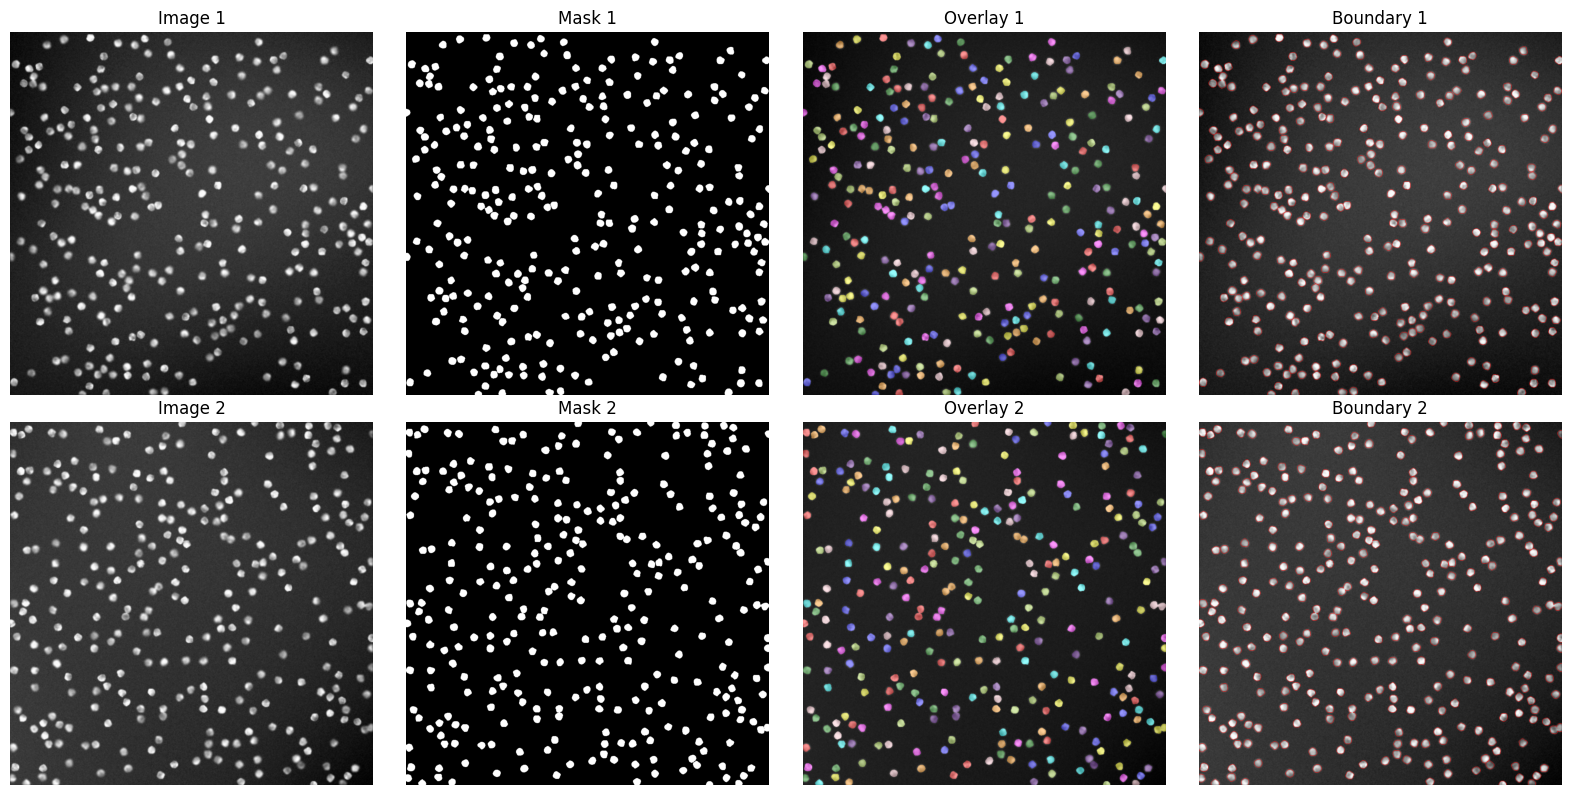

In [25]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import numpy as np

# File names
images = ['1GRAY.tif', '2GRAY.tif']
masks  = ['1.tif',  '2.tif']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i in range(len(images)):
    # Load image and mask
    img = imread(f'data/{images[i]}', as_gray=True)
    mask = imread(f'data/{masks[i]}', as_gray=True) > 0.5

    # Normalize image for blending
    img_norm = (img - img.min()) / (img.max() - img.min())

    # Create overlay
    labeled_mask = label(mask)
    overlay = label2rgb(labeled_mask, image=img_norm, bg_label=0, alpha=0.4)

    # Create boundary-marked image
    boundary = mark_boundaries(img_norm, mask.astype(int), color=(1, 0, 0))  # Red boundaries


    # Plot original, mask, overlay
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f'Image {i+1}')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1}')
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')

    axes[i, 3].imshow(boundary)
    axes[i, 3].set_title(f'Boundary {i+1}')

# Clean up axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

### Quantitative Evaluation

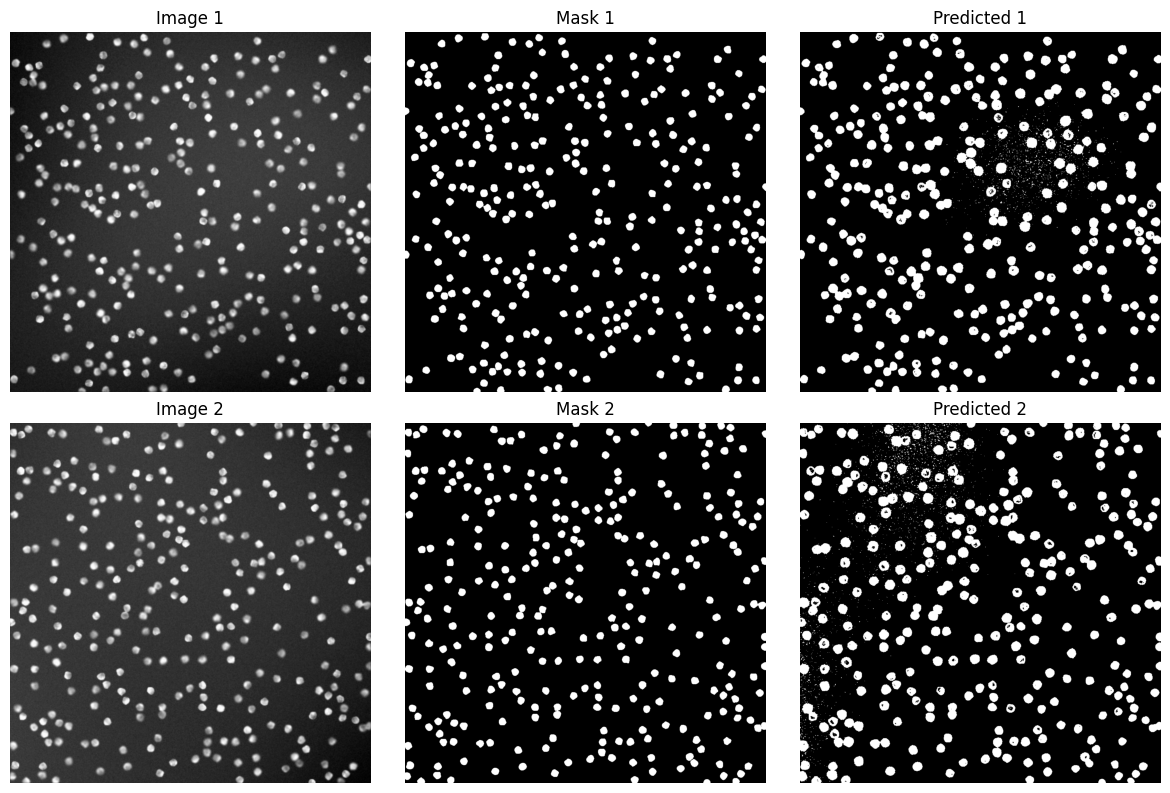

In [27]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import numpy as np

# File names
images = ['1GRAY.tif', '2GRAY.tif']
masks  = ['1.tif',  '2.tif']
preds = ['1PRED.tif', '2PRED.tif']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i in range(len(images)):
    # Load image and mask
    img = imread(f'data/{images[i]}', as_gray=True)
    mask = imread(f'data/{masks[i]}', as_gray=True) > 0.5
    pred = imread(f'data/{preds[i]}', as_gray=True) > 0.5
    
    # Normalize image for blending
    img_norm = (img - img.min()) / (img.max() - img.min())

    
    # Plot original, mask, overlay
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f'Image {i+1}')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1}')
    
    axes[i, 2].imshow(pred, cmap='gray')
    axes[i, 2].set_title(f'Predicted {i+1}')


# Clean up axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [28]:

import numpy as np
from skimage.io import imread

# Load masks (convert 0/255 to binary 0/1)
gt = imread('data/1.tif', as_gray=True) > 0.5
pred = imread('data/1PRED.tif', as_gray=True) > 0.5

# Flatten for metric calculation
gt_flat = gt.flatten()
pred_flat = pred.flatten()

# Dice Coefficient
intersection = np.sum(gt_flat * pred_flat)
dice = (2. * intersection) / (np.sum(gt_flat) + np.sum(pred_flat))
print(f"Dice Coefficient: {dice:.4f}")

# IoU
union = np.sum(np.logical_or(gt_flat, pred_flat))
iou = intersection / union
print(f"IoU: {iou:.4f}")

Dice Coefficient: 0.8110
IoU: 0.6821
